<a href="https://colab.research.google.com/github/ncsu-geoforall-lab/geomorphometry2025_workshop/blob/main/geomorphometry_2025_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop: Propagating DEM Uncertainty to Stream Extraction using GRASS

<a name="start"></a>
### Start GRASS and Create a New Project

First, we'll install GRASS:

In [ ]:
!lsb_release -a

In [ ]:
!pip install rpy2==3.1.0 pandas ipyleaflet

In [ ]:
!add-apt-repository -y ppa:ubuntugis/ubuntugis-unstable
!apt update
!apt-get install -y grass-core grass-dev

In [ ]:
!grass --version

Now, we can import GRASS's Python APIs, `grass.scripts` and `grass.jupyter` into our Python environment.

In [1]:
import sys
import subprocess

# Ask GRASS where its Python packages are to be able to run it from the notebook
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)
import grass.script as gs
import grass.jupyter as gj

With our packages imported, we can now create a new project called "geomorphometry_workshop". Projects are defined by a Coordinate Reference System (CRS). We can set the CRS from a georeferenced file (such as a Geotiff) or an EPSG string. Here, we use [EPSG 3358](https://epsg.io/32632), a projection for NC in meters.

In [ ]:
gs.create_project("geomorphometry_workshop", epsg="32632")

We start a GRASS session in our new project.

In [3]:
gj.init("geomorphometry_workshop");

Draw Computational Region

In [27]:
m = gj.InteractiveMap(use_region=True)
m.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Set Region resolution to 10m (same as TINItaly)

In [4]:
!g.region res=10 -pa

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4782760
south:      4774910
west:       775490
east:       783530
nsres:      10
ewres:      10
rows:       785
cols:       804
cells:      631140


Import Data (this isn't working so well for me..)

In [ ]:
gs.run_command("r.in.wms",
               url="http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?",
               output="elevation",
               format="tiff",
               layers="TINItaly_1_1:tinitaly_dem",
               srs="32632",
              )

TODO: display this data and look at a history

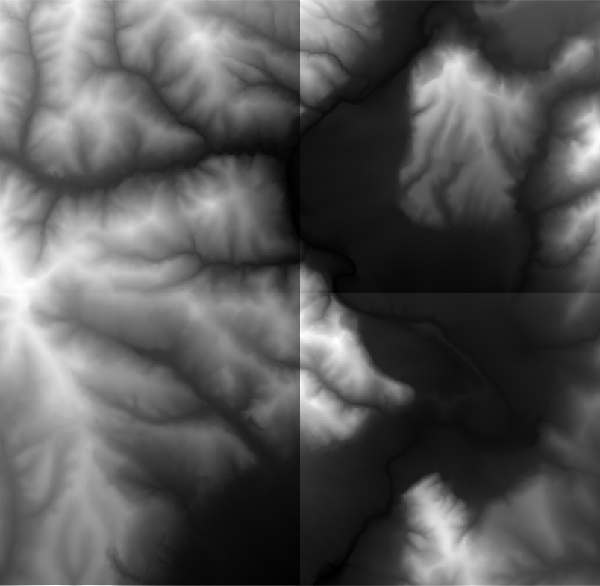

In [59]:
m = gj.Map()
m.d_rast(map="elevation.1")
m.show()

Sample Points

TODO: Statified sampling by landcover to mimic Lidar? Like lower frequency in heavily vegetated areas and none in water/buildings?

In [63]:
gs.run_command("r.random", input="elevation.1", vector="elevrand", n=1000, flags="s")

## Move to R for Kriging

Set up R.

After installing the interactive R kernel, we load it.

In [5]:
%load_ext rpy2.ipython

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

Now, we can use the %%R cell magic. When this cell is interpreted, it's contents will be sent to R. We could also use line magic now with %R which would only send the line to R.

We'll need to install several R packages and download rgrass from github.

In [71]:
%%R
install.packages(c("gstat", "terra", "devtools", "IRkernel"), lib = "~/R/libs", repos = "https://cloud.r-project.org")
devtools::install_git("https://github.com/rsbivand/rgrass")

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R
library(gstat)
library(rgrass)
library(terra)

In [ ]:
%%R
elevrand <- readVECT("elevrand")

Original Workflow:

https://github.com/ncsu-geoforall-lab/GIS714-assignments/blob/main/Surface_Water_Simulations/WaterSim-Geostatistical-Simulations.ipynb

TUTORIAL Option:

https://geobgu.xyz/r/spatial-interpolation-of-point-data.html

FROM CHATGPT

In [ ]:
# Define prediction grid (e.g., 1 m resolution DEM)
grid <- rast(ext(0, 100, 0, 100), resolution = 1) # TODO: Set up match g.region?
crs(grid) <- "EPSG:32633"  # match to your data CRS
grd_pts <- as.data.frame(xyFromCell(grid, 1:ncell(grid)))

# Convert to spatial object for gstat
coordinates(grd_pts) <- ~x + y
gridded(grd_pts) <- TRUE
proj4string(grd_pts) <- CRS("+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs")

# Fit empirical variogram
vg_emp <- variogram(elevrand ~ 1, pts)

# Fit Matern variogram model (gstat uses a workaround via vgm)
vg_model <- vgm(psill = 20, model = "Mat", range = 30, nugget = 1, kappa = 1.0)  # tweak params as needed
vg_fit <- fit.variogram(vg_emp, model = vg_model)

# Set up gstat model for conditional simulation (kriging + random component)
g <- gstat(NULL, id = "elevation", formula = elevation ~ 1, data = pts, model = vg_fit, beta = mean(pts$elevation))

# Perform 100 simulations
n_realizations <- 100
sim_stack <- rast()

for (i in 1:n_realizations) {
  sim <- predict(g, newdata = grd_pts, nsim = 1)
  sim_raster <- rast(as.data.frame(sim)[, 1], template = grid)
  sim_stack <- c(sim_stack, sim_raster)
}

# Name layers
names(sim_stack) <- paste0("sim_", 1:n_realizations)

# Optional: calculate mean simulated DEM
mean_dem <- app(sim_stack, mean)

# Plot example
plot(mean_dem, main = "Mean of 100 Simulated DEMs")

FROM OLD ASSIGNMENT

In [ ]:
%%R
plot(variog4(elevations, max.dist=1000, messages=FALSE), lwd=2)

In [ ]:
%%R
Z.svar <- variog(elevations, max.dist=1000, messages=FALSE)
Z.vgm <- variofit(Z.svar, ini=c(var(elevations$data), 1000), fix.nugget=T, nugget=0)
env.model <- variog.model.env(elevations, obj.var=Z.svar, model=Z.vgm)
plot(Z.svar, envelope=env.model); lines(Z.vgm, lwd=2);